In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

   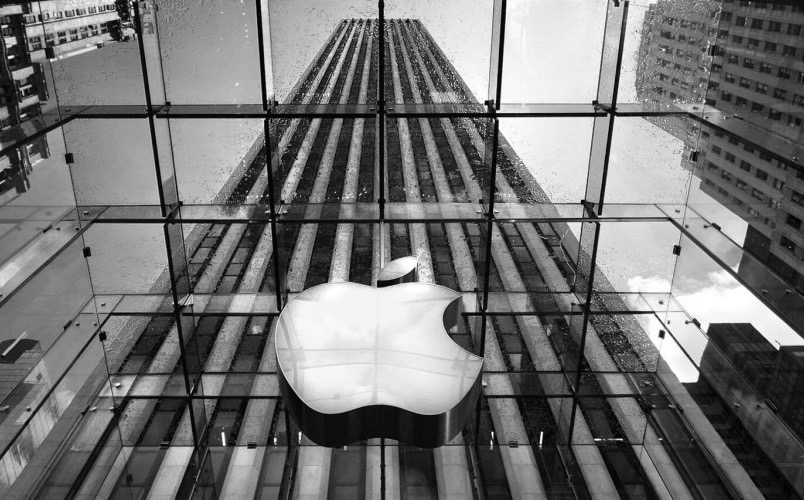

In [ ]:
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

# Gathering Data

This dataset has 1630 rows and 2 columns. In text column, there are user reviews and sentiment column there are -1,0,1 values.

* -1:negative
* 0:neutral
* 1:positive

In [ ]:
data = pd.read_csv("../input/appletwittersentimenttexts/apple-twitter-sentiment-texts.csv")
data.head()

First of all, we write the string equivalents of the numbers in the dataframe. Because these numbers cannot be used directly for the model.

In [ ]:
for i in range(len(data.sentiment)):
    if data.sentiment[i] == -1:
        data["sentiment"][i] = "negative"
    elif data.sentiment[i] == 0:
        data["sentiment"][i] = "neutral"
    else:
        data["sentiment"][i] = "positive"
        
data.head()

# Visualization

In [ ]:
data["sentiment"].value_counts()

In [ ]:
sns.countplot(data["sentiment"]);

In [ ]:
text = " ".join(review for review in data.text)
print ("There are {} words in the combination of all review.".format(len(text)))

In [ ]:
# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Preprocessing

Below are the texts written in the first two lines of the dataset. These texts also contain unnecessary information such as url and mention. This information needs to be cleared for the model to work better.

In [ ]:
data.iloc[1].text

In [ ]:
data.iloc[0].text

In the regex below, it is specified to find and extract urls starting with http, words starting with @, #, $ sign.

In [ ]:
def remove_chars():
    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+|#[a-zA-Z]+|$[a-zA-Z]+|@[a-zA-Z]+|[,.^_$*%-;鶯!?:]')
    for i in range(len(data["text"])):
        data["text"][i] = pattern.sub('', data["text"][i])
remove_chars()

data.head()

## Removing Stopwords

**Stop Words:** A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) that a search engine has been programmed to ignore, both when indexing entries for searching and when retrieving them as the result of a search query. We would not want these words to take up space in our database, or taking up valuable processing time.

In [ ]:
data_test = data.copy()
stop = stopwords.words('english')
data_test["text"] = data_test["text"].str.lower().str.split()
data_test["text"] = data_test["text"].apply(lambda x: [item for item in x if item not in stop])
data_test.head()

While removing the stopwords, we had to separate the words of each sentence within the list. In order to avoid problems in the next use, we should combine these words and make them a sentence again.

In [ ]:
def concate_words(data):
    for i in range(len(data)):
        #print(train_data.iloc[i])
        data.iloc[i] = " ".join(data.iloc[i])
    return data

data_test["text"] = concate_words(data_test["text"])

In [ ]:
data_test.head()

## Tokenization and Pad Sequences

**Tokenization** : A token is, very simply, a piece of data that stands in for another, more valuable piece of information. Tokens have virtually no value on their own - they are only useful because they represent something bigger. Tokenization is essentially splitting a phrase, sentence, paragraph, or an entire text document into smaller units, such as individual words or terms. Each of these smaller units are called tokens.

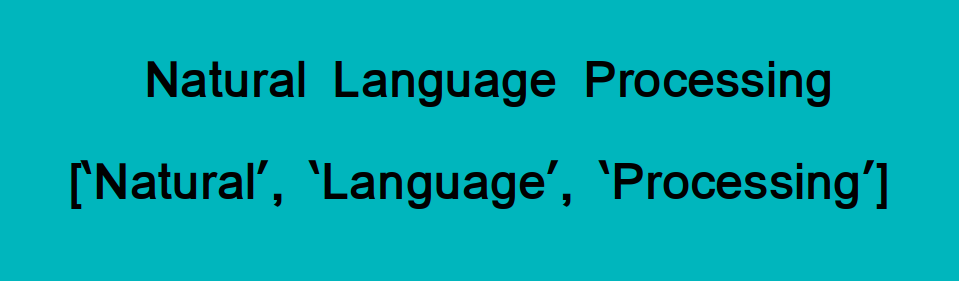

**pad_sequences** : The pad_sequences() function in the Keras deep learning library can be used to pad variable length sequences.



In [ ]:
max_words = 500
max_len= 20

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', data_test['text'][0])
X, tokenizer = tokenize_pad_sequences(data_test['text'])
print('After Tokenization & Padding \n', X[0])

# Bulding Model

We convert the sentiment part to numeric values ​​and equalize it to the y variable. Then we divide the data into two as train and test.

In [ ]:
y = pd.get_dummies(data_test['sentiment'])
train_data, test_data, train_label, test_label = train_test_split(X, y, test_size=0.10, random_state=1)

print('Train Set ->', train_data.shape, train_label.shape)
print('Test Set ->', test_data.shape, test_label.shape)

**Embedding Layer**: The Embedding layer is initialized with random weights and will learn an embedding for all of the words in the training dataset.

It is a flexible layer that can be used in a variety of ways, such as:

* It can be used alone to learn a word embedding that can be saved and used in another model later.
* It can be used as part of a deep learning model where the embedding is learned along with the model itself.
* It can be used to load a pre-trained word embedding model, a type of transfer learning.


**LSTM (Long-Short Term Memory)**: Long Short-Term Memory (LSTM) networks are a type of recurrent neural network capable of learning order dependence in sequence prediction problems. This is a behavior required in complex problem domains like machine translation, speech recognition, and more.

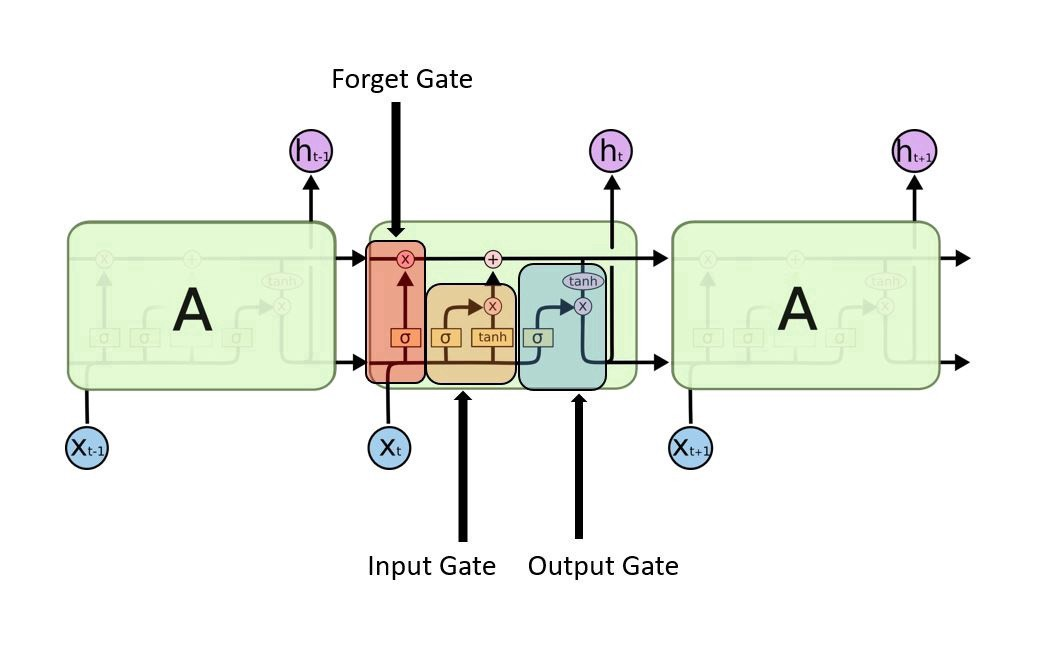

In [ ]:
vocab_size = tokenizer.document_count

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 16),
    tf.keras.layers.LSTM(16, activation="relu"),
    tf.keras.layers.Dense(3, activation="softmax")
])

model.summary()

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
history = model.fit(train_data, train_label, epochs=10, validation_data=(test_data, test_label))

In [ ]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
    
plot_graphs(history, "acc")
plot_graphs(history, "loss")

In [ ]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(train_data, train_label)
rf.score(test_data, test_label)